# Data loading and processing

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor

%matplotlib inline

In [2]:
#Loading train and test data (test set for competition will be called evaluate)
data = pd.read_csv('train.csv', index_col = 'Id')
evaluate = pd.read_csv('test.csv', index_col = 'Id')

In [3]:
#appending both sets to be sure, that made changes whould be the same
full = data.append(evaluate, ignore_index=False, sort = False)

## Features engineering

In [4]:
#creating three typeas of variables: qualitive (only for factorization), 
#ordinal (to change names so that bigger number is better) and quantitive (no need for change)
qualitive = ['MSSubClass', 'MSZoning', 'BldgType', 'Heating',
             'GarageType', 'GarageFinish', 
                 'SaleType', 'SaleCondition',
                'Foundation', 'Fence']

ordinal = ['Street', 'LotShape', 'Basement', 'AfterRemod', 'Utilities', 'LandSlope', 'KitchenQual', 'PavedDrive', 
                'CentralAir', 'PoolQC']
    
quantitive = ['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'GarageArea', 
             'MiscVal', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 
              'Pool_QC_Area', 'Garage_QC_Area', 'LotFrontage', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF',
             'FullBath', 'TotRmsAbvGrd']




In [5]:
for i in qualitive:
    full[i] = full[i].factorize()[0]

In [6]:
full['Basement'] = full['BsmtQual'].notnull().map({True: 1, False: 0})

In [7]:
full['AfterRemod'] = full['YearBuilt'].where(full['YearBuilt'] == full['YearRemodAdd']).isna().map({True: 1, False: 0})

In [8]:
full['GarageArea'] = full['GarageArea'].fillna(0)

In [9]:
full['KitchenQual'] = full['KitchenQual'].map({'Fa': 0,
                    'TA': 1, 
                    'Gd': 2, 
                    'Ex': 3})
full['KitchenQual'] = full['KitchenQual'].fillna(0)

In [10]:
full['Street'] = full['Street'].map({'Grvl': 0,
                    'Pave': 1})

In [11]:
full['LotShape'] = full['LotShape'].map({'IR3': 0,
                    'IR2': 1, 
                    'IR1': 2, 
                    'Reg': 3})

In [12]:
full['Utilities'] = full['Utilities'].map({'AllPub': 1,
                    'NoSeWa': 0})
full['Utilities'] = full['Utilities'].fillna(0)

In [13]:
full['LandSlope'] = full['LandSlope'].map({'Sev': 0,
                    'Mod': 1, 
                    'Gtl': 2})

In [14]:
full['PavedDrive'] = full['PavedDrive'].map({'N': 0,
                    'P': 1, 
                    'Y': 2})

In [15]:
full['CentralAir'] = full['CentralAir'].map({'N': 0,
                    'Y': 1})

In [16]:
full['PoolQC'] = full['PoolQC'].map({'Fa': 1,
                    'TA': 2, 
                    'Gd': 3, 
                    'Ex': 4})
full['PoolQC'] = full['PoolQC'].fillna(0)

In [17]:
full['Pool_QC_Area'] = full['PoolQC'] * full['PoolArea']

In [18]:
full['GarageQual'] = full['GarageQual'].map({'Po': 1, 
                    'Fa': 2,
                    'TA': 3, 
                    'Gd': 4, 
                    'Ex': 5})
full['GarageQual'] = full['GarageQual'].fillna(0)

In [19]:
full['Garage_QC_Area'] = full['GarageQual'] * full['GarageArea']

In [20]:
 full['LotFrontage'] = full['LotFrontage'].fillna(0)

In [21]:
 full['GarageCars'] = full['GarageCars'].fillna(0)

In [22]:
 full['FullBath'] = full['FullBath'].fillna(0)

In [23]:
 full['TotRmsAbvGrd'] = full['TotRmsAbvGrd'].fillna(0)

In [24]:
 full['1stFlrSF'] = full['1stFlrSF'].fillna(0)

In [25]:
 full['TotalBsmtSF'] = full['TotalBsmtSF'].fillna(0)

## Sets

In [26]:
#joining all needen columns in one DataFrame
full = full[qualitive].join(full[quantitive]).join(full[ordinal]).join(full['SalePrice'])

In [27]:
#division of trainging and evaluate sets
data = full[full['SalePrice'].isna() == False]
evaluate = full[full['SalePrice'].isna() == True].drop(labels = 'SalePrice', axis = 1)

In [28]:
#removing outliers and leverage values
mean = data.describe().loc['mean', 'SalePrice']
std = data.describe().loc['std', 'SalePrice']
data = data[data['SalePrice'] < (mean + 5*std)]

In [29]:
#creating X and y sets
y = data['SalePrice']
X = data.drop(labels = 'SalePrice', axis = 1)

In [30]:
#division of sets for training and scoring
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# Decision Tree model learning

In [31]:
#training Decision Tree without limits for hiperparameters
tree = DecisionTreeRegressor(random_state = 1)
tree.fit(X=X_train, y=y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [32]:
#checking a score (low - probably overfitted model)
tree_score = tree.score(X_test, y_test)
tree_score 

0.6783625994781812

In [33]:
#exporting tree to external file for visualisation
export_graphviz(tree, out_file='graph')

# Bagging

In [34]:
#Training Decistion Tree with Bagging
bag = BaggingRegressor(n_estimators=200, n_jobs=4, random_state=1)
bag.fit(X=X_train, y=y_train)

BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=200, n_jobs=4, oob_score=False, random_state=1,
         verbose=0, warm_start=False)

In [35]:
bag_score = bag.score(X_test, y_test)
bag_score

0.8775642367580626

# Boosting

In [36]:
#Training Decistion Tree with Boosting
boost = GradientBoostingRegressor(n_estimators=500)
boost.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [37]:
boost_score = boost.score(X_test, y_test)
boost_score

0.888279414036513

In [38]:
boost_feature_importances = pd.Series(boost.feature_importances_, X_train.columns).sort_values(ascending=False)
boost_feature_importances

OverallQual       0.472963
GrLivArea         0.183479
TotalBsmtSF       0.063287
GarageCars        0.053287
1stFlrSF          0.040633
KitchenQual       0.038455
LotArea           0.031758
YearBuilt         0.026554
LotFrontage       0.013783
MSSubClass        0.011591
Garage_QC_Area    0.010316
OverallCond       0.009839
FullBath          0.007496
CentralAir        0.005008
OpenPorchSF       0.004610
GarageArea        0.004307
ScreenPorch       0.004114
SaleCondition     0.003502
MSZoning          0.003237
SaleType          0.001743
LotShape          0.001544
GarageType        0.001405
TotRmsAbvGrd      0.001318
AfterRemod        0.001261
EnclosedPorch     0.000913
GarageFinish      0.000855
PavedDrive        0.000715
PoolArea          0.000594
LandSlope         0.000380
Foundation        0.000291
BldgType          0.000188
Fence             0.000179
Pool_QC_Area      0.000129
3SsnPorch         0.000114
MiscVal           0.000081
Heating           0.000041
PoolQC            0.000016
S

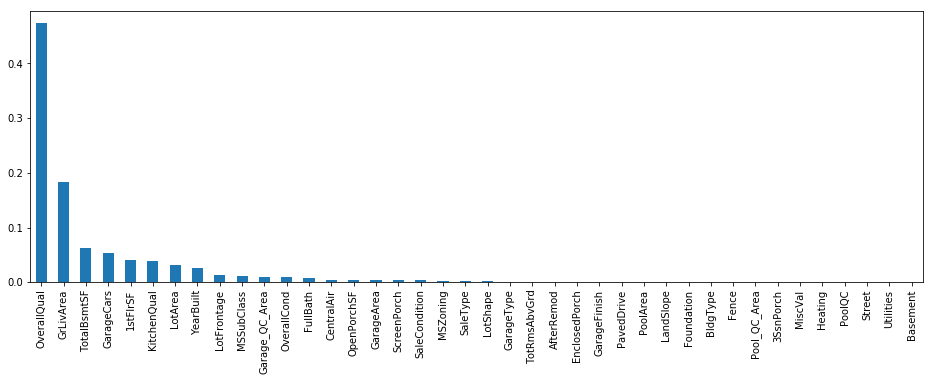

In [39]:
boost_feature_importances.plot(kind = 'bar', figsize=(16, 5))

# Chossing best hiperparameters with GridSearchCV

In [40]:
#using GridSearchCV module to find best hiperparameters for Decision Tree with usage of Cross Validation
estimator = DecisionTreeRegressor(random_state = 1)
param_grid = {'max_depth': range(1, 5),
              'min_samples_leaf': range (1, 10),
             'min_samples_split': range (2, 10)}
grid = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=3, n_jobs=4)
grid.fit(X=X, y=y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best'),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'max_depth': range(1, 5), 'min_samples_leaf': range(1, 10), 'min_samples_split': range(2, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [41]:
#checking the best hiperparameters
best_params = pd.Series(grid.best_params_)
best_params

max_depth            4
min_samples_leaf     7
min_samples_split    2
dtype: int64

In [42]:
#model scoring - much better than tree without limits
grid_score = grid.score(X=X_test, y=y_test)
grid_score

0.8324071856119729

# Random forest training

In [43]:
#Random Forest training using the best hiperparameters
sqrt = int(np.sqrt(len(X_train.columns)))
forest = RandomForestRegressor(max_depth=best_params['max_depth'],
                              min_samples_leaf = best_params['min_samples_leaf'],
                              min_samples_split = best_params['min_samples_split'], n_estimators=100, random_state = 1,
                              bootstrap=True, max_features=sqrt, n_jobs=4)
forest.fit(X=X_train, y=y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=7,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=4, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [44]:
forest_score = forest.score(X=X_test, y=y_test)
forest_score

0.8060336518997302

In [45]:
#checking importance of used variables
feature_importances = pd.Series(forest.feature_importances_, X_train.columns).sort_values(ascending=False)
feature_importances

OverallQual       0.160051
GrLivArea         0.138936
GarageCars        0.085828
FullBath          0.083543
YearBuilt         0.076982
TotalBsmtSF       0.073279
GarageArea        0.063445
Garage_QC_Area    0.060933
KitchenQual       0.058563
1stFlrSF          0.041931
TotRmsAbvGrd      0.030016
LotArea           0.028909
OpenPorchSF       0.023979
Foundation        0.018913
GarageFinish      0.014231
MSSubClass        0.010974
LotFrontage       0.005850
CentralAir        0.003377
GarageType        0.003324
SaleType          0.002988
MSZoning          0.002843
OverallCond       0.001887
SaleCondition     0.001820
BldgType          0.001733
PavedDrive        0.001486
LotShape          0.001241
ScreenPorch       0.001118
Basement          0.000966
LandSlope         0.000438
AfterRemod        0.000308
EnclosedPorch     0.000070
Fence             0.000041
MiscVal           0.000000
3SsnPorch         0.000000
PoolArea          0.000000
Pool_QC_Area      0.000000
Street            0.000000
H

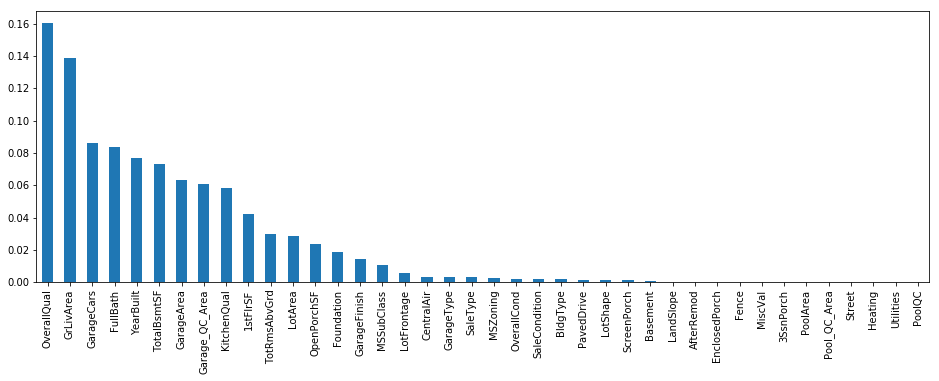

In [46]:
feature_importances.plot(kind = 'bar', figsize=(16, 5))

## Least square regression

In [47]:
#preparing datasets for Linear Regression (only ordinal and quantitive data)
X_train_lin = X_train[quantitive].join(X_train[ordinal])
X_test_lin = X_test[quantitive].join(X_test[ordinal])

In [48]:
#Linear Regression using Least Square Method
square = LinearRegression(fit_intercept=True, copy_X=True, n_jobs = 4, normalize = True)
square.fit(X_train_lin,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=4, normalize=True)

In [49]:
square_score = square.score(X_test_lin,y_test)
square_score

0.856902574882436

In [50]:
#checking coefficients
square.intercept_

-1073633.1729439069

In [51]:
#coefficients of the model
pd.Series(square.coef_, X_train_lin.columns)

LotArea                0.611871
OverallQual        16267.420931
OverallCond         4469.803245
YearBuilt            481.100041
GarageArea           -55.564982
MiscVal               -0.066543
OpenPorchSF           -1.078794
EnclosedPorch         39.647113
3SsnPorch             -7.088101
ScreenPorch           76.134150
PoolArea             -91.307562
Pool_QC_Area         487.536347
Garage_QC_Area        24.610609
LotFrontage           24.244027
GrLivArea             35.694983
GarageCars          8018.042477
TotalBsmtSF           27.957952
1stFlrSF               2.041989
FullBath           -4887.115201
TotRmsAbvGrd        2595.350379
Street             19908.900785
LotShape           -3358.688368
Basement          -19865.732717
AfterRemod          9848.576835
Utilities          51246.885393
LandSlope          -7488.727602
KitchenQual        14225.782998
PavedDrive          1084.905154
CentralAir         -3183.944471
PoolQC           -292459.028196
dtype: float64

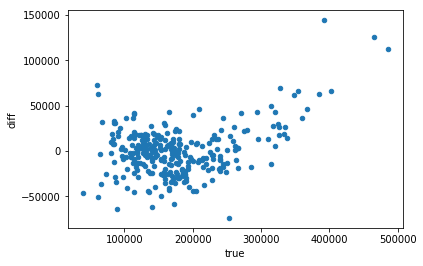

In [52]:
#creating a graph with residual values
prediction = square.predict(X = X_test_lin)
compare = pd.DataFrame({'prediction': prediction, 'true': y_test, 'diff': (y_test - prediction)})
compare.plot.scatter( x = 'true', y = 'diff')

# Ridge Regression

In [53]:
#Linear Regression using Ridge Method
ridge = Ridge(fit_intercept=True, random_state=1, alpha=1, normalize=True)
ridge.fit(X_train_lin,y_train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
   random_state=1, solver='auto', tol=0.001)

In [54]:
ridge_score = ridge.score(X = X_test_lin, y = y_test)
ridge_score

0.8044516131755975

In [55]:
ridge.intercept_

-480803.748353448

In [56]:
#coefficients of the model
pd.Series(ridge.coef_, X_train_lin.columns)

LotArea               0.345859
OverallQual        8712.563935
OverallCond        1431.015890
YearBuilt           205.451093
GarageArea           19.638080
MiscVal               0.016488
OpenPorchSF          36.870625
EnclosedPorch        -5.473804
3SsnPorch            -1.167658
ScreenPorch          42.235077
PoolArea            -12.660136
Pool_QC_Area         -4.957061
Garage_QC_Area        7.133712
LotFrontage          23.282762
GrLivArea            16.109677
GarageCars         7434.701018
TotalBsmtSF          13.113044
1stFlrSF             14.554048
FullBath           8419.437851
TotRmsAbvGrd       3497.384607
Street            18602.094677
LotShape          -4739.596891
Basement           6678.430281
AfterRemod         3832.575898
Utilities         28726.113856
LandSlope         -5778.264772
KitchenQual       13229.086455
PavedDrive         2741.090109
CentralAir         7254.324828
PoolQC            -8199.213060
dtype: float64

## Lasso Regression

In [57]:
#Linear Regression using Lasso Method
lasso = Lasso(fit_intercept=True, copy_X=True, random_state=1, max_iter=20000, alpha=4, normalize=True)
lasso.fit(X=X_train_lin, y=y_train)

Lasso(alpha=4, copy_X=True, fit_intercept=True, max_iter=20000,
   normalize=True, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)

In [58]:
lasso_score = lasso.score(X=X_test_lin, y=y_test)
lasso_score

0.8575485549287962

In [59]:
lasso.intercept_

-1018515.2186705528

In [60]:
#coefficients of the model
pd.Series(lasso.coef_, X_train_lin.columns)

LotArea                0.600703
OverallQual        16523.468399
OverallCond         4374.387219
YearBuilt            452.794661
GarageArea            -0.989642
MiscVal               -0.000000
OpenPorchSF            0.498958
EnclosedPorch         29.552995
3SsnPorch             -3.278350
ScreenPorch           71.490071
PoolArea             -36.446146
Pool_QC_Area         363.325896
Garage_QC_Area         8.588024
LotFrontage           13.017831
GrLivArea             34.515206
GarageCars          6505.162652
TotalBsmtSF           23.974748
1stFlrSF               4.874266
FullBath           -3169.114680
TotRmsAbvGrd        2461.124593
Street             17816.538383
LotShape           -3313.038730
Basement          -15238.233490
AfterRemod          8964.000080
Utilities          48011.949044
LandSlope          -7305.378516
KitchenQual        14398.204606
PavedDrive          1064.346439
CentralAir         -1557.873141
PoolQC           -230348.706698
dtype: float64

## DummyRegressor

In [61]:
#comparing obtained scores with score from Dummy Regressor
dummy = DummyRegressor(strategy='mean')
dummy.fit(X=X_train, y=y_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [62]:
dummy.score(X = X_test, y=y_test)

-0.0027327000850954075

## Predictions for test data

In [63]:
#collecting scores of all created models
scores = pd.Series({'tree': tree_score,
'grid': grid_score,
'forest': forest_score,
'square': square_score,
'lasso': lasso_score,
'ridge': ridge_score,
'bag': bag_score,
'boost': boost_score})
scores.sort_values(ascending = False)

boost     0.888279
bag       0.877564
lasso     0.857549
square    0.856903
grid      0.832407
forest    0.806034
ridge     0.804452
tree      0.678363
dtype: float64

In [64]:
scores.idxmax()

'boost'

In [65]:
#creating file for submission using model with the best score
predict = bag.predict(X = evaluate)

In [66]:
results = pd.DataFrame({'Id': evaluate.index,
                        'SalePrice': predict})

In [67]:
results = results.set_index(keys = 'Id')

In [68]:
results.to_csv('submission.csv')